<a href="https://colab.research.google.com/github/sonalshreya25/respiratoryDiagnostic/blob/dev/RespiratoryDiagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Mount Google Drive**

This code mounts my Google Drive into the Colab environment so I can read and write files directly — including loading audio data, saving spectrograms, and storing Grad-CAM visualizations.

Once I run this cell, I’ll be prompted to authenticate with my Google account. After authentication, my Drive becomes available at the path `/content/drive/`.


In [6]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


# **Step 2: Set Paths**

This block imports the required Python libraries for file handling, data processing, audio loading, and visualization.

It also defines paths to important files and folders located in Google Drive, including:
- `root_dir`: the base directory of the ICBHI dataset
- `audio_dir`: folder containing the `.wav` recordings and annotation files
- `diagnosis_file`: contains patient IDs and their diagnosis labels
- `train_patients_file` and `test_patients_file`: define which patients belong to the training and testing sets
- `train_test_file`: contains train/test split information at the recording level
- `events_folder`: includes event-level annotations (e.g., wheezes and crackles)


In [7]:
# STEP 2: Set Paths
import os
import pandas as pd
from glob import glob
import librosa
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Change this to your Google Drive path
root_dir = "/content/drive/MyDrive/ICBHI_final_database"
audio_dir = os.path.join(root_dir, "recordings_annotations")
diagnosis_file = os.path.join(root_dir, "diagnosis_data.txt")
train_patients_file = os.path.join(root_dir, "train_data.txt")
test_patients_file = os.path.join(root_dir, "test_data.txt")
train_test_file = os.path.join(root_dir, "train_test_data.txt")
events_folder = os.path.join(root_dir, "events/events")


In [9]:
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np


# Checking for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Setting seed for repeatability
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensuring deterministic behavior for CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cuda:0


In [10]:
# Initializing Weights & Biases
wandb.init(entity="usf-alpha-neurons",project="respiratory_diagnosis")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sonalshreya (usf-alpha-neurons) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# **Step 3: Load Diagnosis and Patient Split Data**

This block loads important metadata required to organize and label the dataset:

- The `diagnosis_df` DataFrame reads patient diagnosis information from `diagnosis_data.txt`, which includes a patient ID and their corresponding label (diagnosis class).
- Patient IDs are converted to string type to ensure consistent matching later.

Next, the training and testing patient splits are read from `train_data.txt` and `test_data.txt`, respectively. These lists help assign each recording to the correct dataset partition for model training and evaluation.


In [11]:
# STEP 3: Load diagnosis and patient split data
diagnosis_df = pd.read_csv(diagnosis_file, header=None, sep='\t', names=['Patient_ID', 'Diagnosis'])
diagnosis_df['Patient_ID'] = diagnosis_df['Patient_ID'].astype(str)

with open(train_patients_file, 'r') as f:
    train_patients = [line.strip() for line in f.readlines()]

with open(test_patients_file, 'r') as f:
    test_patients = [line.strip() for line in f.readlines()]


# **Step 4: Scan Audio and Annotation Files**

This step scans through all the `.wav` audio recordings and their corresponding `.txt` annotation files in the dataset.

For each audio file:
- The patient ID is extracted from the filename.
- It checks if the corresponding annotation file exists.
- The patient’s diagnosis is retrieved using their ID.
- The file is categorized as part of the train/test/unknown split based on the patient ID.

All relevant metadata — such as patient ID, file name, full paths, diagnosis, and dataset split — is compiled into a dictionary and appended to a list.

Finally, the list is converted into a `pandas` DataFrame (`df`) that serves as the master reference table for the dataset.


In [12]:
#STEP 4: Scan all audio + annotation files
data = []

for wav_file in tqdm(glob(os.path.join(audio_dir, "*.wav"))):
    base_name = os.path.basename(wav_file)
    patient_id = base_name.split('_')[0]
    txt_file = wav_file.replace(".wav", ".txt")

    if not os.path.exists(txt_file):
        continue

    diagnosis = diagnosis_df.loc[diagnosis_df['Patient_ID'] == patient_id, 'Diagnosis']
    diagnosis = diagnosis.values[0] if not diagnosis.empty else None

    if patient_id in train_patients:
        split = 'train'
    elif patient_id in test_patients:
        split = 'test'
    else:
        split = 'unknown'

    data.append({
        'Patient_ID': patient_id,
        'File': base_name,
        'WAV_Path': wav_file,
        'TXT_Path': txt_file,
        'Diagnosis': diagnosis,
        'Split': split
    })

df = pd.DataFrame(data)


100%|██████████| 920/920 [00:01<00:00, 912.60it/s] 


# **Step 5: Extract Crackle and Wheeze Events from Annotation Files**

This step processes the event-level annotation files to identify whether each recording contains audible crackles and/or wheezes.

- The function `extract_events` builds the path to each recording’s corresponding `_events.txt` file.
- It checks for the presence of the words "crackle" or "wheeze" (case-insensitive) in the file.
- If found, it sets binary flags `has_crackle` and `has_wheeze` accordingly.

These values are applied to every file listed in the DataFrame, and two new columns — `Crackles` and `Wheezes` — are added to indicate the presence of these features.


In [13]:
# STEP 5: Extract crackle and wheeze events from event files
def extract_events(file_name):
    base_name = os.path.splitext(file_name)[0]
    events_file = os.path.join(events_folder, base_name + '_events.txt')
    has_crackle, has_wheeze = 0, 0
    try:
        with open(events_file, 'r') as f:
            for line in f:
                if 'crackle' in line.lower():
                    has_crackle = 1
                if 'wheeze' in line.lower():
                    has_wheeze = 1
    except FileNotFoundError:
        pass
    return pd.Series([has_crackle, has_wheeze])

df[['Crackles', 'Wheezes']] = df['File'].apply(extract_events)


# **Step 6: Merge Refined Train/Test Split from File**

This step updates the train/test split information in the main DataFrame using a refined version of the split provided in `train_test_data.txt`.

- The file is loaded into a DataFrame with columns `FileBase` (base filename) and `Split` (either `train` or `test`).
- A new `File` column is created by appending `.wav` to match the filenames in the main DataFrame.
- The old `Split` column is dropped from the main DataFrame to avoid conflict.
- A merge is performed to update the split labels based on the actual file names.
- Any files that were not found in the split file are assigned the split label `unknown`.

This ensures that every audio file is now properly assigned to the training, testing, or unknown group.


In [14]:
# STEP 6: Merge refined train/test data from shared file
split_df = pd.read_csv(
    train_test_file,
    sep='\t',
    header=None,
    names=['FileBase', 'Split']
)
split_df['File'] = split_df['FileBase'] + '.wav'
split_df.drop(columns='FileBase', inplace=True)

df = df.drop(columns=['Split'])  # Remove old one
df = df.merge(split_df, on='File', how='left')
df['Split'] = df['Split'].fillna('unknown')


# **Step 7: Display the Final DataFrame**

This step displays the final shape and a preview of the constructed DataFrame (`df`).

By this point, the DataFrame includes:
- File-level metadata (e.g., filename, paths)
- Patient-level information (e.g., diagnosis)
- Audio event features (`Crackles`, `Wheezes`)
- The final `Split` column indicating whether each file belongs to the training, testing, or unknown set

This serves as the master reference table that will be used throughout the preprocessing and model training pipeline.


In [15]:
# STEP 7: Display the final DataFrame
print(" Final DataFrame shape:", df.shape)
df.head()


 Final DataFrame shape: (920, 8)


,Patient_ID,File,WAV_Path,TXT_Path,Diagnosis,Crackles,Wheezes,Split
0,160,160_1b3_Tc_mc_AKGC417L.wav,/content/drive/MyDrive/ICBHI_final_database/re...,/content/drive/MyDrive/ICBHI_final_database/re...,COPD,0,1,test
1,160,160_1b4_Ar_mc_AKGC417L.wav,/content/drive/MyDrive/ICBHI_final_database/re...,/content/drive/MyDrive/ICBHI_final_database/re...,COPD,1,1,test
2,158,158_1p4_Tc_mc_AKGC417L.wav,/content/drive/MyDrive/ICBHI_final_database/re...,/content/drive/MyDrive/ICBHI_final_database/re...,COPD,0,1,train
3,160,160_1b3_Al_mc_AKGC417L.wav,/content/drive/MyDrive/ICBHI_final_database/re...,/content/drive/MyDrive/ICBHI_final_database/re...,COPD,1,1,test
4,159,159_1b1_Ll_sc_Meditron.wav,/content/drive/MyDrive/ICBHI_final_database/re...,/content/drive/MyDrive/ICBHI_final_database/re...,Healthy,0,0,train


# **Step 8: Generate and Save Spectrograms**

This step defines a helper function to generate both `.npy` and `.png` spectrograms from audio recordings.

- The `generate_and_save_spectrogram()` function loads an audio file using `librosa`, computes its Short-Time Fourier Transform (STFT), and converts it into decibel scale.
- The decibel spectrogram is normalized and saved as a `.npy` file — this will be used as input for model training.
- A visual version of the spectrogram is also created and saved as a `.png` image for use in visualizations and Grad-CAM++ overlays.

All generated files are stored in a folder called `spectrograms` inside the dataset root directory.


In [16]:
#Step 8
import librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np

# Create output folder
output_dir = os.path.join(root_dir, "spectrograms")
os.makedirs(output_dir, exist_ok=True)

# Spectrogram helper
def generate_and_save_spectrogram(wav_path, file_name, duration=3, n_fft=2048, hop_length=512):
    y, sr = librosa.load(wav_path, sr=None, duration=duration)

    # STFT + dB conversion
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    # Normalize for training (.npy)
    S_db_norm = (S_db - np.min(S_db)) / (np.max(S_db) - np.min(S_db))

    # Save .npy
    npy_path = os.path.join(output_dir, file_name.replace(".wav", ".npy"))
    np.save(npy_path, S_db_norm)

    # Save .png
    png_path = os.path.join(output_dir, file_name.replace(".wav", ".png"))
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(png_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    return npy_path, png_path


# **Step 9 : Batch Generate Spectrograms**

This loop iterates over each row in the main DataFrame and generates spectrograms for each `.wav` file using the previously defined `generate_and_save_spectrogram()` function.

- For each audio file, it checks if the corresponding `.npy` and `.png` spectrograms already exist. If they do, it skips regeneration and simply records the paths in the DataFrame.
- If the spectrograms do not exist, it generates them and stores their paths (`Spectrogram_Array` and `Spectrogram_Image`) in new columns in the DataFrame.
- Any errors during processing are caught and logged with a warning message.

This step ensures that spectrograms are created once, stored efficiently, and reused for both training and visualization.


In [17]:
# ✅ Step 9: Spectrogram Generation with Enhanced Visual & Signal Resolution

import librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np

# 📁 Create output folder
output_dir = os.path.join(root_dir, "spectrograms_high_resolution")
os.makedirs(output_dir, exist_ok=True)

# 🎛️ Spectrogram Parameters (High-Resolution)
n_fft = 4096         # Increased FFT size → better frequency resolution
hop_length = 256     # Smaller hop → better time resolution
duration = 3         # Duration (sec) to load from audio

# 🆕 Optional: Pitch shift augmentation for rare training classes
def augment_pitch_shift(y, sr):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-2, 2))

# 🎨 High-res spectrogram generation + saving
def generate_and_save_spectrogram(wav_path, file_name, diagnosis=None, split=None):
    y, sr = librosa.load(wav_path, sr=None, duration=duration)

    # 🔄 Augment rare classes only during training
    rare_classes = ['Asthma', 'LRTI']
    if split == 'train' and diagnosis in rare_classes:
        y = augment_pitch_shift(y, sr)

    # 🎧 Compute STFT and dB spectrogram
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    # 🔁 Normalize for .npy output
    S_db_norm = (S_db - np.min(S_db)) / (np.max(S_db) - np.min(S_db))

    # 💾 Save .npy file (used for model input)
    npy_path = os.path.join(output_dir, file_name.replace(".wav", ".npy"))
    np.save(npy_path, S_db_norm)

    # 💾 Save high-res .png for Grad-CAM overlays
    png_path = os.path.join(output_dir, file_name.replace(".wav", ".png"))
    plt.figure(figsize=(12, 6), dpi=300)  # 🎨 Bigger image & higher DPI
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(png_path, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

    return npy_path, png_path

from tqdm import tqdm

# ✅ Loop through all rows in df and generate spectrograms
for idx, row in tqdm(df.iterrows(), total=len(df), desc="🔄 Generating Spectrograms"):
    file = row['File']
    npy_path = os.path.join(output_dir, file.replace('.wav', '.npy'))
    png_path = os.path.join(output_dir, file.replace('.wav', '.png'))

    # ✅ Skip if BOTH npy and png already exist (previous run completed this file)
    if os.path.exists(npy_path) and os.path.exists(png_path):
        df.at[idx, 'Spectrogram_Array'] = npy_path
        df.at[idx, 'Spectrogram_Image'] = png_path
        continue

    # 🔁 Else process and save
    try:
        npy_path, png_path = generate_and_save_spectrogram(
            row['WAV_Path'],
            row['File'],
            diagnosis=row['Diagnosis'],
            split=row['Split']
        )
        df.at[idx, 'Spectrogram_Array'] = npy_path
        df.at[idx, 'Spectrogram_Image'] = png_path
    except Exception as e:
        print(f"⚠️ Failed to process {row['File']}: {e}")



🔄 Generating Spectrograms: 100%|██████████| 920/920 [00:00<00:00, 1069.33it/s]


# **Step 10: Save DataFrame with Spectrogram Paths**

After generating spectrograms for all audio files, this step saves the updated DataFrame (`df`) as a `.pkl` file (`df_with_spectrograms.pkl`) in the project root directory.

The saved DataFrame includes:
- Original metadata (file paths, labels, split info, etc.)
- New columns pointing to the saved `.npy` and `.png` spectrograms

This serialized file can be loaded later to skip the entire preprocessing step and go straight into training or visualization.


In [18]:
#Step 10
df.to_pickle(os.path.join(root_dir, "df_with_spectrograms.pkl"))
print("Saved metadata with spectrogram paths.")


Saved metadata with spectrogram paths.


# **Step 11: Filter Data, Encode Labels, and Visualize Distribution**

This step prepares the dataset for model training by performing the following tasks:

- **Filtering**: It removes any entries labeled as `'unknown'` in the `Split` column, keeping only those explicitly assigned to either the training or test set.

- **Label Encoding**: Uses `LabelEncoder` from `sklearn` to convert diagnosis labels (strings) into numerical class IDs, which are required for training a classification model. The result is stored in a new column called `EncodedLabel`.

- **Class Overview**: Prints the list of unique diagnosis classes in encoded form and stores the total number of classes for use in the model setup.

- **Visualization**: A bar plot is generated to show the distribution of diagnosis labels across training and test sets. This helps verify that the classes are somewhat balanced and that the dataset split is reasonable.


✅ Total valid samples after filtering: 919
🔠 Original Encoded Classes: ['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI']
📌 Grouped Classes: ['Healthy', 'Infectious', 'Obstructive', 'Structural']


<ipython-input-19-d28757f1b299>:42: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


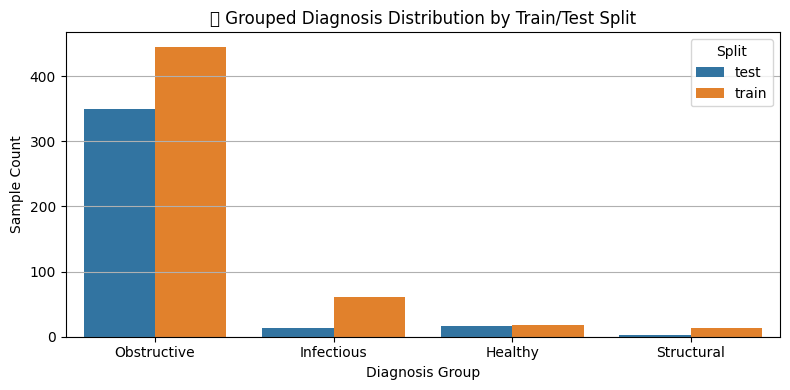

In [19]:
# ✅ Step 11: Filter unknown patients
df = df[df['Split'].isin(['train', 'test'])].reset_index(drop=True)
print(f"✅ Total valid samples after filtering: {df.shape[0]}")

# ✅ Encode original diagnosis labels (optional but useful for analysis)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['EncodedLabel'] = label_encoder.fit_transform(df['Diagnosis'].astype(str))
print("🔠 Original Encoded Classes:", list(label_encoder.classes_))

# ✅ Group diagnoses into medically-informed superclasses
group_mapping = {
    'COPD': 'Obstructive',
    'Asthma': 'Obstructive',
    'Pneumonia': 'Infectious',
    'Bronchitis': 'Infectious',
    'URTI': 'Infectious',
    'LRTI': 'Infectious',
    'Bronchiolitis': 'Infectious',
    'Bronchiectasis': 'Structural',
    'Healthy': 'Healthy'
}

df['Diagnosis_Group'] = df['Diagnosis'].map(group_mapping)

# ✅ Encode new grouped classes
from sklearn.preprocessing import LabelEncoder
group_encoder = LabelEncoder()
df['GroupLabel'] = group_encoder.fit_transform(df['Diagnosis_Group'])
print("📌 Grouped Classes:", list(group_encoder.classes_))

# ✅ Visualize group-wise label distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Diagnosis_Group', order=df['Diagnosis_Group'].value_counts().index, hue='Split')
plt.title("📊 Grouped Diagnosis Distribution by Train/Test Split")
plt.xlabel("Diagnosis Group")
plt.ylabel("Sample Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# **Step 12: Split into Train/Test Sets and Save**

This step separates the full dataset into two DataFrames:
- `train_df`: contains only samples marked as part of the training set
- `test_df`: contains only samples marked for testing

To support reproducibility and efficient reloading later, both splits are saved as `.pkl` (pickle) files:
- `train_split.pkl`
- `test_split.pkl`

These files can be loaded in future sessions to skip reprocessing and directly begin model training or evaluation.


In [20]:
# ✅ Step 12: Stratified 80:20 split based on GroupLabel
from sklearn.model_selection import train_test_split

# 🧹 Remove any NaN GroupLabel just in case
df = df[df['GroupLabel'].notna()].reset_index(drop=True)

# ✅ Perform stratified split
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['GroupLabel'],
    random_state=42
)

# Reset indices
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# 💾 Save to .pkl for reproducibility
train_split_path = os.path.join(root_dir, "train_split_stratified.pkl")
test_split_path = os.path.join(root_dir, "test_split_stratified.pkl")

train_df.to_pickle(train_split_path)
test_df.to_pickle(test_split_path)

# 🔎 Show result summary
print(f"📁 Stratified Train split saved to: {train_split_path}")
print(f"📁 Stratified Test split saved to: {test_split_path}")
print(f"🔢 Train class distribution:\n{train_df['GroupLabel'].value_counts()}")
print(f"🔢 Test class distribution:\n{test_df['GroupLabel'].value_counts()}")


📁 Stratified Train split saved to: /content/drive/MyDrive/ICBHI_final_database/train_split_stratified.pkl
📁 Stratified Test split saved to: /content/drive/MyDrive/ICBHI_final_database/test_split_stratified.pkl
🔢 Train class distribution:
GroupLabel
2    635
1     59
0     28
3     13
Name: count, dtype: int64
🔢 Test class distribution:
GroupLabel
2    159
1     15
0      7
3      3
Name: count, dtype: int64


# **Step 13: Reload Train and Test Split Data**

This step reloads the previously saved `train_df` and `test_df` DataFrames from their `.pkl` files.  
It ensures that the dataset splits are preserved across notebook sessions without needing to repeat earlier preprocessing steps.

After loading, it prints the shapes of both datasets to confirm successful reloading.


In [21]:
# ✅ Step 13: Reload stratified train/test split
train_split_path = os.path.join(root_dir, "train_split_stratified.pkl")
test_split_path = os.path.join(root_dir, "test_split_stratified.pkl")

train_df = pd.read_pickle(train_split_path)
test_df = pd.read_pickle(test_split_path)

print(f"🧪 Reloaded Stratified Splits:")
print(f" - Train shape: {train_df.shape}")
print(f" - Test shape: {test_df.shape}")
print(f" - Train class counts:\n{train_df['GroupLabel'].value_counts()}")
print(f" - Test class counts:\n{test_df['GroupLabel'].value_counts()}")


🧪 Reloaded Stratified Splits:
 - Train shape: (735, 13)
 - Test shape: (184, 13)
 - Train class counts:
GroupLabel
2    635
1     59
0     28
3     13
Name: count, dtype: int64
 - Test class counts:
GroupLabel
2    159
1     15
0      7
3      3
Name: count, dtype: int64


In [22]:
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset

class Spectrogram2DDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'Spectrogram_Image']
        label = self.df.loc[idx, 'GroupLabel']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [25]:
from torch.utils.data import DataLoader
from torchvision import transforms

img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_ds = Spectrogram2DDataset(train_df, transform=img_transforms)
test_ds = Spectrogram2DDataset(test_df, transform=img_transforms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

print("✅ Dataloaders are ready!")

sample_dataset = Spectrogram2DDataset(train_df, transform=img_transforms)

# Log 3 spectrogram images to wandb
for i in range(3):  # or use random indices
    image, label = sample_dataset[i]

    # wandb.Image takes PIL or tensor directly
    wandb.log({
        f"Sample Spectrogram {i+1}": wandb.Image(image, caption=f"Label: {label}")
    })


✅ Dataloaders are ready!


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_df['GroupLabel'].unique())

model = resnet18(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last two layers: layer4 and fc
for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True

# Replace the final layer
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


In [28]:
from sklearn.utils.class_weight import compute_class_weight
import torch

classes = np.unique(train_df['GroupLabel'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_df['GroupLabel']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
learning_rate = 1e-4
weight_decay = 1e-5
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
    weight_decay=weight_decay
)
wandb.config.update({
    "model": "ResNet18",
    "loss_function": "CrossEntropyLoss (weighted)",
    "optimizer": "Adam",
    "learning_rate": learning_rate,
    "weight_decay": weight_decay,
    "class_weights": {
        f"Group {cls}": float(weight)
        for cls, weight in zip(classes, class_weights)
    }
})

In [30]:
from sklearn.metrics import accuracy_score


num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    # 📊 Metrics
    avg_loss = total_loss / len(train_loader)
    train_acc = accuracy_score(all_labels, all_preds)

    # 🪄 Log to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_loss,
        "train_accuracy": train_acc
    })

    print(f"📚 Epoch {epoch+1} | Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f}")


📚 Epoch 1 | Train Loss: 0.3158 | Train Acc: 0.8626
📚 Epoch 2 | Train Loss: 0.1487 | Train Acc: 0.9497
📚 Epoch 3 | Train Loss: 0.0785 | Train Acc: 0.9769
📚 Epoch 4 | Train Loss: 0.0516 | Train Acc: 0.9878
📚 Epoch 5 | Train Loss: 0.0407 | Train Acc: 0.9946
📚 Epoch 6 | Train Loss: 0.0266 | Train Acc: 0.9959
📚 Epoch 7 | Train Loss: 0.0218 | Train Acc: 1.0000
📚 Epoch 8 | Train Loss: 0.0177 | Train Acc: 1.0000
📚 Epoch 9 | Train Loss: 0.0189 | Train Acc: 1.0000
📚 Epoch 10 | Train Loss: 0.0115 | Train Acc: 1.0000
📚 Epoch 11 | Train Loss: 0.0089 | Train Acc: 1.0000
📚 Epoch 12 | Train Loss: 0.0099 | Train Acc: 1.0000
📚 Epoch 13 | Train Loss: 0.0068 | Train Acc: 1.0000
📚 Epoch 14 | Train Loss: 0.0061 | Train Acc: 1.0000
📚 Epoch 15 | Train Loss: 0.0060 | Train Acc: 1.0000
📚 Epoch 16 | Train Loss: 0.0054 | Train Acc: 1.0000
📚 Epoch 17 | Train Loss: 0.0052 | Train Acc: 1.0000
📚 Epoch 18 | Train Loss: 0.0056 | Train Acc: 1.0000
📚 Epoch 19 | Train Loss: 0.0046 | Train Acc: 1.0000
📚 Epoch 20 | Train Lo

In [32]:
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, classification_report
)
import torch.nn.functional as F
import numpy as np

# Inference on TEST SET
model.eval()
test_preds, test_labels, test_probs = [], [], []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(y.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_probs = np.array(test_probs)

# Compute weighted metrics
test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')
test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')

# Compute AUC (multi-class)
try:
    test_auc = roc_auc_score(
        y_true=np.eye(num_classes)[test_labels],
        y_score=test_probs,
        average='weighted',
        multi_class='ovr'
    )
except Exception as e:
    test_auc = None
    print("AUC could not be computed:", str(e))

# Print classification report
print("Test Classification Report:")
print(classification_report(test_labels, test_preds, target_names=group_encoder.classes_))
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test F1 Score:  {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
if test_auc is not None:
    print(f"Test ROC AUC:   {test_auc:.4f}")

# Log to Weights & Biases
import wandb
wandb.log({
    "test/accuracy": test_acc,
    "test/f1_score": test_f1,
    "test/precision": test_precision,
    "test/recall": test_recall,
    "test/auc": test_auc if test_auc is not None else 0.0
})


Test Classification Report:
              precision    recall  f1-score   support

     Healthy       0.40      0.29      0.33         7
  Infectious       0.67      0.67      0.67        15
 Obstructive       0.96      0.99      0.98       159
  Structural       1.00      0.33      0.50         3

    accuracy                           0.92       184
   macro avg       0.76      0.57      0.62       184
weighted avg       0.92      0.92      0.92       184

Test Accuracy:  0.9239
Test F1 Score:  0.9178
Test Precision: 0.9182
Test Recall:    0.9239
Test ROC AUC:   0.9873


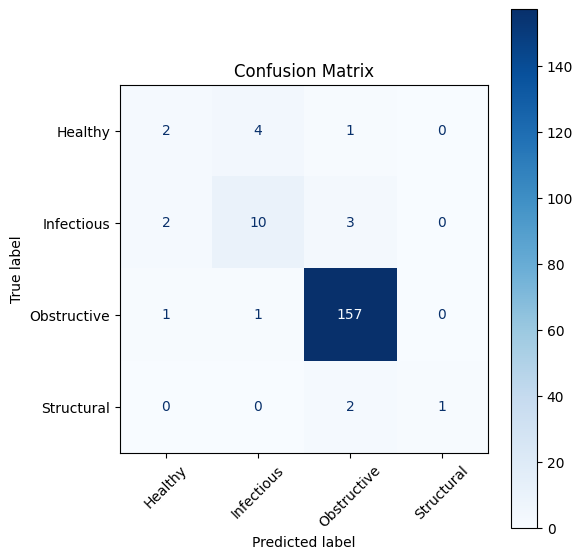

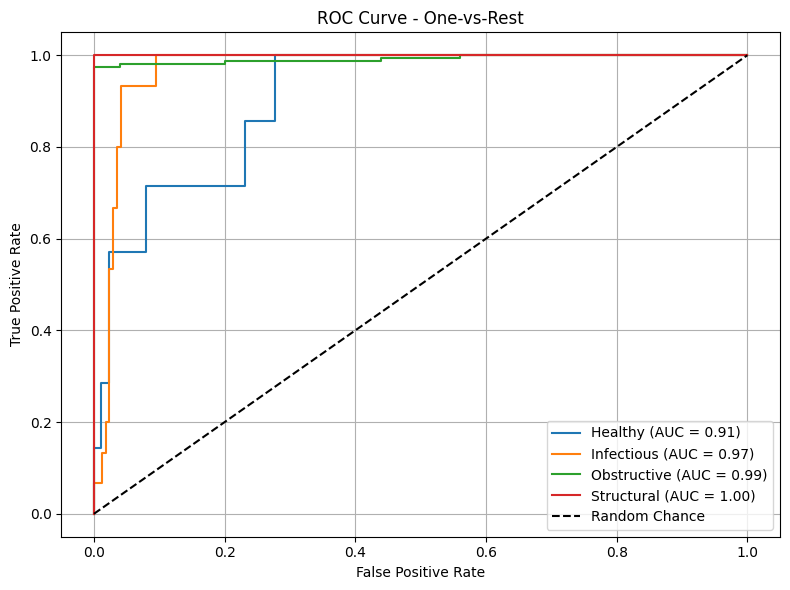

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# ✅ Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=group_encoder.classes_)

fig_cm, ax_cm = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax_cm, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# ✅ Log confusion matrix to W&B
wandb.log({"Confusion Matrix": wandb.Image(fig_cm)})

# ✅ ROC Curve - One-vs-Rest
test_labels_binarized = label_binarize(test_labels, classes=np.arange(num_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

fig_roc, ax_roc = plt.subplots(figsize=(8, 6))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    ax_roc.plot(fpr[i], tpr[i], label=f"{group_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")

ax_roc.plot([0, 1], [0, 1], 'k--', label='Random Chance')
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.set_title("ROC Curve - One-vs-Rest")
ax_roc.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Log ROC to W&B
wandb.log({"ROC Curve": wandb.Image(fig_roc)})


In [34]:
import os
import torch
import wandb

# Define the model path in your Google Drive
model_save_path = "/content/drive/MyDrive/ICBHI_final_database/resnet18_20epoch_grouped.pth"

# Save model state dictionary
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to: {model_save_path}")

# Log model as an artifact to Weights & Biases
artifact = wandb.Artifact(
    name="resnet18_20epoch-icbhi-grouped",
    type="model",
    description="ResNet18 model trained on ICBHI with grouped diagnosis labels",
    metadata={
        "architecture": "ResNet18",
        "input": "2D Spectrograms",
        "labels": list(group_encoder.classes_),
        "epochs": 20,
        "optimizer": "Adam",
        "loss": "Weighted CrossEntropy",
        "class_weights": class_weights.cpu().numpy().tolist()
    }
)

artifact.add_file(model_save_path)
wandb.log_artifact(artifact)


Model saved to: /content/drive/MyDrive/ICBHI_final_database/resnet18_20epoch_grouped.pth


<Artifact resnet18_20epoch-icbhi-grouped>

In [35]:
wandb.finish()

epoch,▁▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test/accuracy,▁
test/auc,▁
test/f1_score,▁
test/precision,▁
test/recall,▁
train_accuracy,▁▅▇▇████████████████
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test/accuracy,0.92391
test/auc,0.98728
